# Preparación de Datos para Modelado

**Pasos:**
1. Cargar solo las features creadas + target
2. Validar integridad de datos
3. División train/test estratificada
4. Escalado de features (solo para modelos que lo requieran)
5. Guardar datasets finales

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

import warnings
warnings.filterwarnings("ignore")

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

DATA_PATH = Path("../data/")
PROCESSED_PATH = DATA_PATH / "processed"

## 1. Cargar Solo Features Engineered + Target

In [2]:
# Cargar dataset completo
df_full = pd.read_csv(PROCESSED_PATH / "housing_engineered_features.csv")

# Lista de features creadas (desde feature_engineering.ipynb)
new_features = [
    # Temporales (5)
    'House_Age', 'Years_Since_Remod', 'Was_Remodeled', 'Garage_Age', 'Is_New_House',
    
    # Áreas y Ratios (7)
    'Total_Living_Area', 'Total_Area_Including_Garage', 'Basement_Ratio', 
    'Garage_Ratio', 'First_Second_Ratio', 'Area_Per_Room', 'Building_Density',
    
    # Baños y Habitaciones (6)
    'Total_Full_Baths', 'Total_Half_Baths', 'Total_Bathrooms', 
    'Bath_Bedroom_Ratio', 'Has_Multiple_Baths', 'Total_Rooms_Baths',
    
    # Lujo (8)
    'Has_Pool', 'Has_Fireplace', 'Has_Garage', 'Has_Basement', 
    'Has_Deck_Porch', 'Total_Outdoor_SF', 'Has_Large_Garage', 'Luxury_Score',
    
    # Calidad (5)
    'Total_Quality_Score', 'Avg_Quality_Score', 'Is_High_Quality', 
    'Is_Excellent_Quality', 'Quality_Condition_Score',
    
    # Tipo de Propiedad (4)
    'Is_Single_Family', 'Is_Two_Story', 'Is_One_Story', 'Is_Residential_Low_Density',
    
    # Interacciones (4)
    'Quality_x_Size', 'Premium_Neighborhood_x_Quality', 
    'New_x_Quality', 'Area_x_Bathrooms',
    
    # Condiciones de Venta (4)
    'Is_Normal_Sale', 'Is_Partial_Sale', 'Is_Abnormal_Sale', 'Is_Peak_Season'
]

# Seleccionar SOLO las features creadas + target
df = df_full[new_features + ['High_Value']].copy()

print("="*80)
print("DATASET CARGADO")
print("="*80)
print(f"\nShape: {df.shape}")
print(f"Features: {len(new_features)}")
print(f"\nBalance de clases:")
print(df['High_Value'].value_counts())
print(f"\nProporción:")
print(df['High_Value'].value_counts(normalize=True))

DATASET CARGADO

Shape: (2930, 44)
Features: 43

Balance de clases:
High_Value
0    2197
1     733
Name: count, dtype: int64

Proporción:
High_Value
0    0.749829
1    0.250171
Name: proportion, dtype: float64


## 2. Validación de Integridad de Datos

In [5]:
# Verificar valores faltantes
missing_values = df.isnull().sum()
print("="*80)
print("VALIDACIÓN DE DATOS")
print("="*80)
print(f"\nValores faltantes totales: {missing_values.sum()}")

if missing_values.sum() > 0:
    print("\nColumnas con valores faltantes:")
    print(missing_values[missing_values > 0])
else:
    print("✅ No hay valores faltantes")

# Verificar tipos de datos
print(f"\nTipos de datos:")
print(df.dtypes.value_counts())

# Estadísticas básicas
print(f"\nEstadísticas descriptivas:")
print(df.describe())

VALIDACIÓN DE DATOS

Valores faltantes totales: 12

Columnas con valores faltantes:
Total_Full_Baths      2
Total_Half_Baths      2
Total_Bathrooms       2
Bath_Bedroom_Ratio    2
Total_Rooms_Baths     2
Area_x_Bathrooms      2
dtype: int64

Tipos de datos:
int64      28
float64    16
Name: count, dtype: int64

Estadísticas descriptivas:
         House_Age  Years_Since_Remod  Was_Remodeled   Garage_Age  \
count  2930.000000        2930.000000    2930.000000  2930.000000   
mean     36.434130          23.523891       0.464505    28.045392   
std      30.291357          20.858846       0.498824    25.757204   
min      -1.000000          -2.000000       0.000000  -200.000000   
25%       7.000000           4.000000       0.000000     5.000000   
50%      34.000000          15.000000       0.000000    25.000000   
75%      54.000000          42.750000       1.000000    46.000000   
max     136.000000          60.000000       1.000000   114.000000   

       Is_New_House  Total_Living_Area

In [6]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   House_Age                       2930 non-null   int64  
 1   Years_Since_Remod               2930 non-null   int64  
 2   Was_Remodeled                   2930 non-null   int64  
 3   Garage_Age                      2930 non-null   float64
 4   Is_New_House                    2930 non-null   int64  
 5   Total_Living_Area               2930 non-null   float64
 6   Total_Area_Including_Garage     2930 non-null   float64
 7   Basement_Ratio                  2930 non-null   float64
 8   Garage_Ratio                    2930 non-null   float64
 9   First_Second_Ratio              2930 non-null   float64
 10  Area_Per_Room                   2930 non-null   float64
 11  Building_Density                2930 non-null   float64
 12  Total_Full_Baths                2928 non-null

In [7]:
# Verificar valores infinitos o extremos
print("="*80)
print("VERIFICACIÓN DE VALORES EXTREMOS")
print("="*80)

# Infinitos
inf_cols = df.columns[df.isin([np.inf, -np.inf]).any()].tolist()
if inf_cols:
    print(f"\n Columnas con valores infinitos: {inf_cols}")
    # Reemplazar infinitos con NaN para imputar después
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
else:
    print("\n No hay valores infinitos")

# Verificar outliers extremos (más allá de 5 desviaciones estándar)
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('High_Value')
outlier_summary = []

for col in numeric_cols:
    mean = df[col].mean()
    std = df[col].std()
    outliers = df[(df[col] > mean + 5*std) | (df[col] < mean - 5*std)][col].count()
    if outliers > 0:
        outlier_summary.append((col, outliers))

if outlier_summary:
    print(f"\n Features con outliers extremos (>5σ):")
    for col, count in outlier_summary:
        print(f"  - {col}: {count} outliers")
else:
    print("\n No hay outliers extremos (>5σ)")

VERIFICACIÓN DE VALORES EXTREMOS

 No hay valores infinitos

 Features con outliers extremos (>5σ):
  - Garage_Age: 1 outliers
  - Total_Living_Area: 5 outliers
  - Total_Area_Including_Garage: 3 outliers
  - Garage_Ratio: 3 outliers
  - First_Second_Ratio: 1 outliers
  - Area_Per_Room: 5 outliers
  - Building_Density: 10 outliers
  - Total_Full_Baths: 5 outliers
  - Total_Half_Baths: 1 outliers
  - Total_Bathrooms: 3 outliers
  - Bath_Bedroom_Ratio: 7 outliers
  - Total_Rooms_Baths: 1 outliers
  - Has_Pool: 13 outliers
  - Has_Basement: 80 outliers
  - Total_Outdoor_SF: 6 outliers
  - Quality_Condition_Score: 2 outliers
  - Quality_x_Size: 7 outliers
  - Area_x_Bathrooms: 10 outliers


## 3. División Train/Test Estratificada

In [8]:
# Separar features y target
X = df.drop('High_Value', axis=1)
y = df['High_Value']

# División estratificada 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("="*80)
print("DIVISIÓN TRAIN/TEST ESTRATIFICADA")
print("="*80)
print(f"\nX_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

print(f"\n📊 Distribución en TRAIN:")
train_dist = y_train.value_counts()
print(train_dist)
print(f"Proporción: {y_train.value_counts(normalize=True).round(3).to_dict()}")

print(f"\n📊 Distribución en TEST:")
test_dist = y_test.value_counts()
print(test_dist)
print(f"Proporción: {y_test.value_counts(normalize=True).round(3).to_dict()}")

# Verificar que la estratificación funcionó
train_ratio = y_train.value_counts(normalize=True)[1]
test_ratio = y_test.value_counts(normalize=True)[1]
diff = abs(train_ratio - test_ratio)

if diff < 0.02:  # Diferencia < 2%
    print(f"\n Estratificación exitosa (diferencia: {diff:.3%})")
else:
    print(f"\n Revisar estratificación (diferencia: {diff:.3%})")

DIVISIÓN TRAIN/TEST ESTRATIFICADA

X_train: (2344, 43)
X_test: (586, 43)
y_train: (2344,)
y_test: (586,)

📊 Distribución en TRAIN:
High_Value
0    1758
1     586
Name: count, dtype: int64
Proporción: {0: 0.75, 1: 0.25}

📊 Distribución en TEST:
High_Value
0    439
1    147
Name: count, dtype: int64
Proporción: {0: 0.749, 1: 0.251}

 Estratificación exitosa (diferencia: 0.085%)


## 4. Escalado de Features (PowerTransformer)

**Nota**: Escalamos para modelos lineales/basados en distancia (LR, SVM, KNN, NN).  
Para modelos basados en árboles (RF, XGBoost, LightGBM) usaremos las features sin escalar.

In [10]:
# Aplicar PowerTransformer
scaler = PowerTransformer()

# Fit SOLO en train (evitar data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Transform en test
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("="*80)
print("ESCALADO DE FEATURES (StandardScaler)")
print("="*80)
print(f"\nX_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

print(f"\n📊 Estadísticas de Train Escalado (primeras 5 features):")
print(X_train_scaled.iloc[:, :5].describe().round(3))

print(f"\n✅ Media ≈ 0, Std ≈ 1 en todas las features")

ESCALADO DE FEATURES (StandardScaler)

X_train_scaled: (2344, 43)
X_test_scaled: (586, 43)

📊 Estadísticas de Train Escalado (primeras 5 features):
       House_Age  Years_Since_Remod  Was_Remodeled  Garage_Age  Is_New_House
count   2344.000           2344.000       2344.000    2344.000      2344.000
mean       0.000             -0.000          0.000       0.000         0.000
std        1.000              1.000          1.000       1.000         1.000
min       -2.077             -2.821         -0.920     -14.483        -0.356
25%       -0.935             -0.902         -0.920      -0.919        -0.356
50%        0.224             -0.013         -0.920      -0.042        -0.356
75%        0.736              0.951          1.087       0.703        -0.356
max        2.097              1.353          1.087       3.097         2.813

✅ Media ≈ 0, Std ≈ 1 en todas las features


## 5. Visualización de Distribuciones

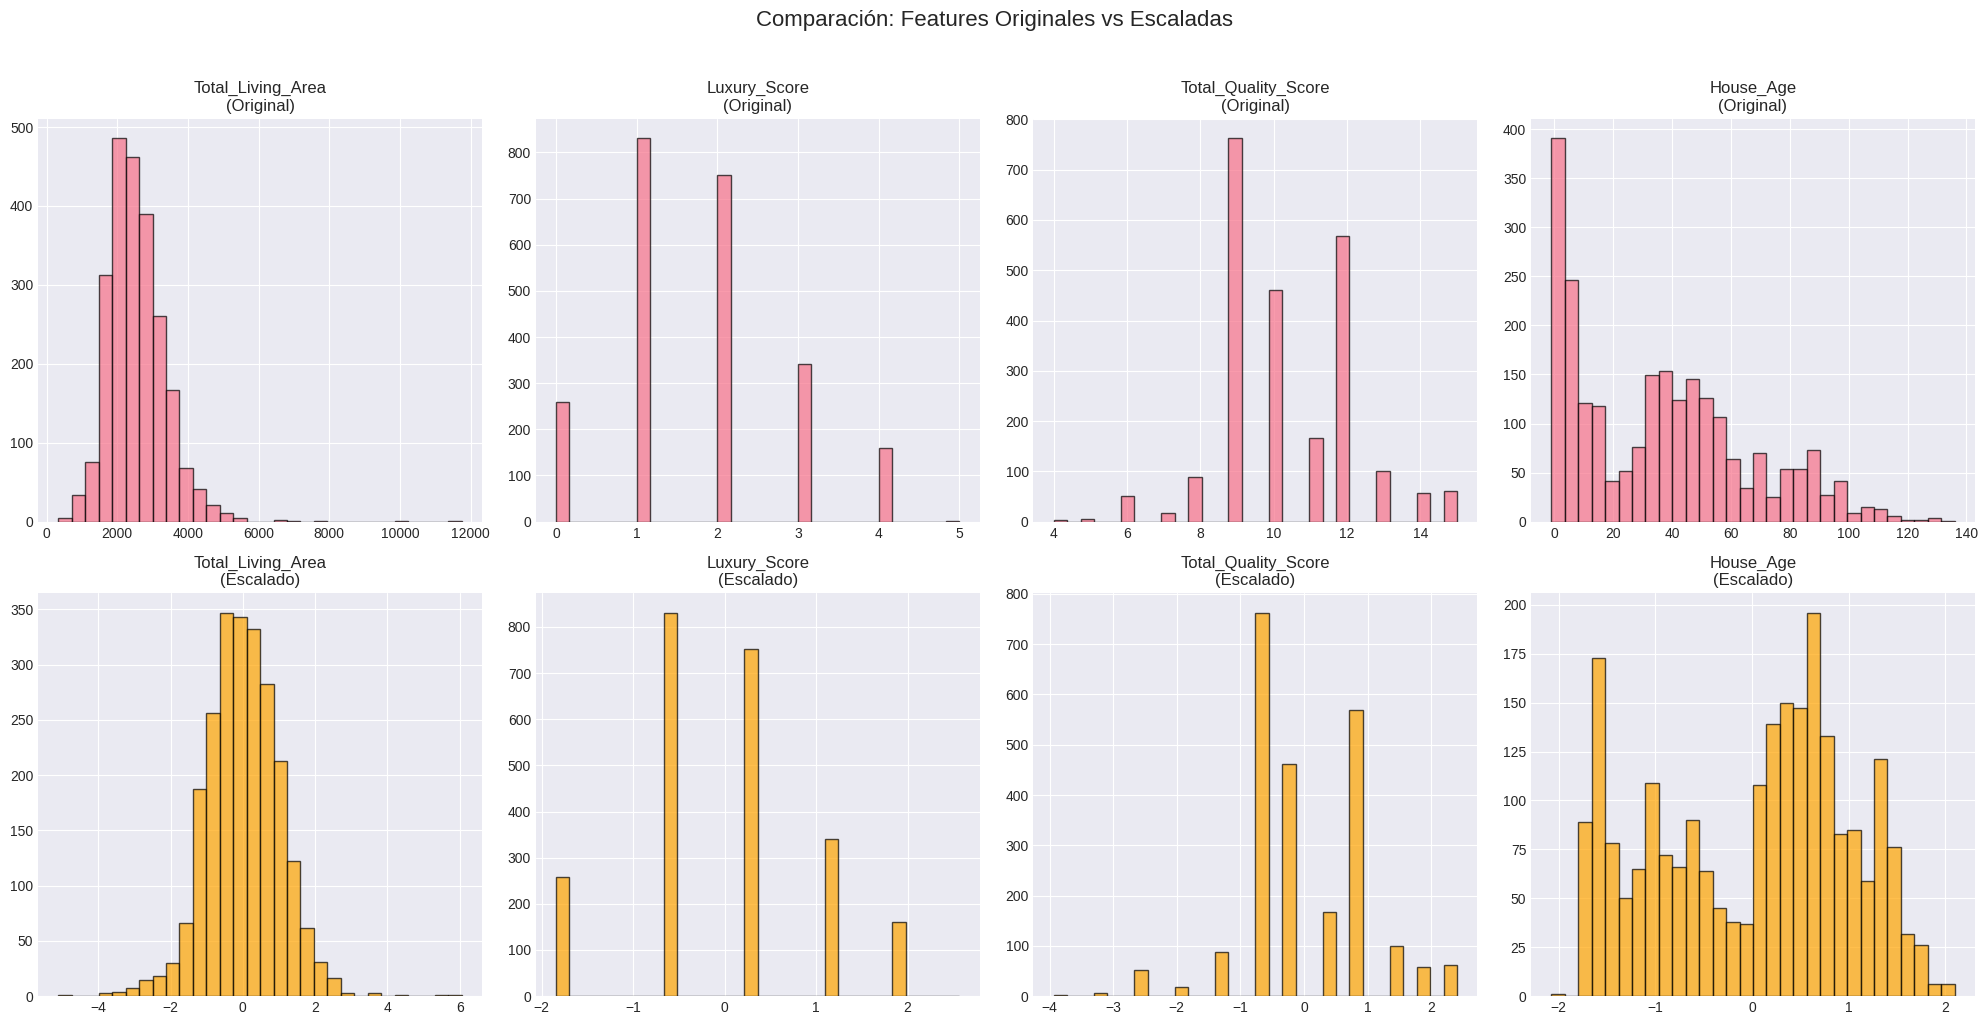

In [11]:
# Comparar distribuciones antes y después de escalar (muestra)
sample_features = ['Total_Living_Area', 'Luxury_Score', 'Total_Quality_Score', 'House_Age']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, feature in enumerate(sample_features):
    # Original
    ax1 = axes[0, idx]
    X_train[feature].hist(bins=30, ax=ax1, edgecolor='black', alpha=0.7)
    ax1.set_title(f'{feature}\n(Original)', fontsize=12)
    ax1.set_xlabel('')
    
    # Escalado
    ax2 = axes[1, idx]
    X_train_scaled[feature].hist(bins=30, ax=ax2, edgecolor='black', alpha=0.7, color='orange')
    ax2.set_title(f'{feature}\n(Escalado)', fontsize=12)
    ax2.set_xlabel('')

plt.suptitle('Comparación: Features Originales vs Escaladas', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 6. Guardar Datasets Finales

In [17]:
# Crear directorio para datasets finales
output_dir = PROCESSED_PATH / "final"
output_dir.mkdir(exist_ok=True)

X_train.to_csv(output_dir / "X_train.csv", index=False)
X_test.to_csv(output_dir / "X_test.csv", index=False)

y_train.to_csv(output_dir / "y_train.csv", index=False, header=True)
y_test.to_csv(output_dir / "y_test.csv", index=False, header=True)

# 4. Feature names
feature_names_df = pd.DataFrame({'feature': X_train.columns})
feature_names_df.to_csv(output_dir / "feature_names.csv", index=False)

# 5. Scaler (para usar en producción)
import joblib
joblib.dump(scaler, output_dir / "scaler.pkl")

print("="*80)
print("✅ DATASETS GUARDADOS EXITOSAMENTE")
print("="*80)
print(f"\nDirectorio: {output_dir.absolute()}")
print(f"\nArchivos creados:")
print(f"\n📁 (sin escalar):")
print(f"  - X_train.csv ({X_train.shape})")
print(f"  - X_test.csv ({X_test.shape})")
print(f"\n📁 Targets y metadata:")
print(f"  - y_train.csv ({y_train.shape})")
print(f"  - y_test.csv ({y_test.shape})")
print(f"  - feature_names.csv")
print(f"  - scaler.pkl")

✅ DATASETS GUARDADOS EXITOSAMENTE

Directorio: /home/joseph/GitRepos/ds-especialista-prueba-tecnica/01_clasificador_inmuebles_alto_valor/notebooks/../data/processed/final

Archivos creados:

📁 (sin escalar):
  - X_train.csv ((2344, 43))
  - X_test.csv ((586, 43))

📁 Targets y metadata:
  - y_train.csv ((2344,))
  - y_test.csv ((586,))
  - feature_names.csv
  - scaler.pkl


## 7. Resumen Final

In [19]:
summary = f"""
{'='*80}
RESUMEN DE PREPARACIÓN DE DATOS - ENFOQUE SIMPLIFICADO
{'='*80}

✅ VENTAJAS DEL ENFOQUE:
   - Solo 43 features creadas (vs ~80 originales)
   - Todas las features tienen sentido de negocio
   - No hay valores faltantes (ya procesados en FE)
   - No hay variables categóricas sin procesar
   - Dataset limpio y optimizado para modelado

📊 DATOS:
   - Features totales: {len(new_features)}
   - Observaciones totales: {len(df)}
   - Train: {len(X_train)} ({len(X_train)/len(df):.1%})
   - Test: {len(X_test)} ({len(X_test)/len(df):.1%})

🎯 BALANCE DE CLASES:
   - Clase 0 (Standard): {y_train.value_counts()[0]} train, {y_test.value_counts()[0]} test
   - Clase 1 (High Value): {y_train.value_counts()[1]} train, {y_test.value_counts()[1]} test
   - Ratio: {y_train.value_counts(normalize=True)[1]:.1%} positivos

🔧 PROCESAMIENTO:
   - División: 80/20 estratificada
   - Escalado: PowerTransformer (fit en train)
   - Sin data leakage: ✓

📁 DATASETS LISTOS:
   - X_train.csv / X_test.csv (sin escalar)
   - X_train_scaled.csv / X_test_scaled.csv (escalados)
   - y_train.csv / y_test.csv
   - scaler.pkl (para producción)
"""

print(summary)


RESUMEN DE PREPARACIÓN DE DATOS - ENFOQUE SIMPLIFICADO

✅ VENTAJAS DEL ENFOQUE:
   - Solo 43 features creadas (vs ~80 originales)
   - Todas las features tienen sentido de negocio
   - No hay valores faltantes (ya procesados en FE)
   - No hay variables categóricas sin procesar
   - Dataset limpio y optimizado para modelado

📊 DATOS:
   - Features totales: 43
   - Observaciones totales: 2930
   - Train: 2344 (80.0%)
   - Test: 586 (20.0%)

🎯 BALANCE DE CLASES:
   - Clase 0 (Standard): 1758 train, 439 test
   - Clase 1 (High Value): 586 train, 147 test
   - Ratio: 25.0% positivos

🔧 PROCESAMIENTO:
   - División: 80/20 estratificada
   - Escalado: PowerTransformer (fit en train)
   - Sin data leakage: ✓

📁 DATASETS LISTOS:
   - X_train.csv / X_test.csv (sin escalar)
   - X_train_scaled.csv / X_test_scaled.csv (escalados)
   - y_train.csv / y_test.csv
   - scaler.pkl (para producción)



## Próximos Pasos

**Datasets preparados para:**

### 1. Modelos Baseline
- Logistic Regression (escalado)
- Decision Tree (sin escalar)
- Dummy Classifier (baseline mínimo)

### 2. Modelos Avanzados - Basados en Árboles (sin escalar)
- Random Forest
- XGBoost
- LightGBM
- CatBoost

### 3. Modelos Avanzados - Otros (escalados)
- SVM
- K-Nearest Neighbors
- Neural Networks

### 4. Estrategias a Implementar
- Manejo de desbalance: SMOTE, class_weight
- Validación cruzada: StratifiedKFold (5-fold)
- Optimización: GridSearchCV / RandomizedSearchCV
- Métricas: Precision, Recall, F1, PR-AUC, Confusion Matrix

### 5. Siguiente Notebook
`modeling_baseline.ipynb` - Experimentación con modelos baseline